# **4.1 Diferencias usando distintos metodos de balanceo (SMOTE, ADASYN, etc) y Arboles de decision:**

Se selccionan las variables explicativas y la respuesta.

In [25]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score,
    recall_score, f1_score, roc_auc_score, classification_report
)
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import ADASYN


In [2]:
df = pd.read_csv("C:\\Users\\taran\\OneDrive\\Desktop\\ML_PF_entrega3\\PF_GestHospitalClasificacion_Entrega3\\data\\PF_POSTPROCES_DATA_LIMPIA.csv")

In [3]:
X = df.drop("readmitted", axis=1)
y = df["readmitted"].map({"NO": 0, "SI": 1})  

Se separan el conjunto de entrenamiento y test.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Creamos vectores con cada tipo de variable para hacer el correcto manejo de las variables antes de modelar.

In [5]:
cat_features = X.select_dtypes(include=["object", "category"]).columns
num_features = X.select_dtypes(include=["int64", "float64"]).columns

A continuación, se crean los pipelines de preprocesamiento, modelo logístico con gridsearch y validación ccruzada estratificada, y modelo de knn con gridsearch y vlaidación cruzada estratificada.

In [6]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)
    ]
)

In [ ]:
# =======================
# 4️⃣ Función de evaluación
# ========================
def evaluar_modelo(modelo, X_test, y_test, nombre_modelo="Modelo"):
    y_pred = modelo.predict(X_test)
    y_proba = modelo.predict_proba(X_test)[:, 1] if hasattr(modelo, "predict_proba") else None

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Reds")
    plt.title(f"Matriz de confusión - {nombre_modelo}")
    plt.xlabel("Predicho")
    plt.ylabel("Real")
    plt.show()

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None

    print(f"=== {nombre_modelo} ===")
    print(f"Accuracy: {accuracy:.3f}")
    print(f"Precision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")
    print(f"F1: {f1:.3f}")
    if auc:
        print(f"AUC: {auc:.3f}")
    print("\nReporte de Clasificación:\n", classification_report(y_test, y_pred))

    return {
        "Modelo": nombre_modelo,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1": f1,
        "AUC": auc
    }


## 4.1.1 Arbol de decision sin tecnicas de balanceo

In [ ]:
# ========================
# 5️⃣ Modelo sin SMOTE
# ========================

modelo = DecisionTreeClassifier( 
    criterion="gini", # también podrías usar 'entropy' o 'log_loss' 
    max_depth=None, # sin límite de profundidad 
    random_state=42 )

pipeline_sin_smote = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", modelo)
])


In [20]:
pipeline_sin_smote.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEnc...
       'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change'],
      dtype='object'))])),
                ('classifier', DecisionTreeClassifier(random_state=42))])

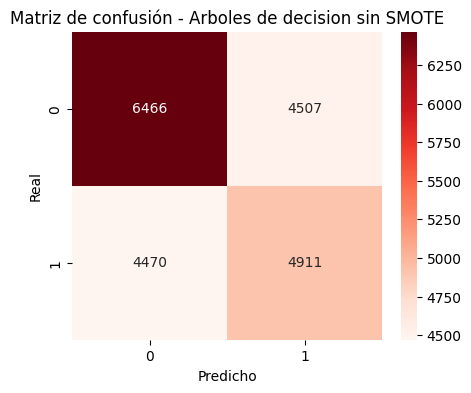

=== Arboles de decision sin SMOTE ===
Accuracy: 0.559
Precision: 0.521
Recall: 0.524
F1: 0.522
AUC: 0.556

Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.59      0.59      0.59     10973
           1       0.52      0.52      0.52      9381

    accuracy                           0.56     20354
   macro avg       0.56      0.56      0.56     20354
weighted avg       0.56      0.56      0.56     20354



In [21]:
result_sin = evaluar_modelo(pipeline_sin_smote, X_test, y_test, nombre_modelo="Arboles de decision sin SMOTE")

## 4.1.2 Arbol de decision con SMOTE

In [22]:
# ========================
# 6️⃣ Modelo con SMOTE
# ========================
modelo = DecisionTreeClassifier( 
    criterion="gini", # también podrías usar 'entropy' o 'log_loss' 
    max_depth=None, # sin límite de profundidad 
    random_state=42 )

pipeline_con_smote = ImbPipeline(steps=[
    ("preprocessor", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("classifier", modelo)
])

In [23]:
pipeline_con_smote.fit(X_train, y_train)

c:\Users\taran\miniconda3\envs\base_finalML_venv\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEnc...
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change'],
      dtype='object'))])),
                ('smote', SMOTE(random_state=42)),
                ('classifier', DecisionTreeClassifier(random_state=42))])

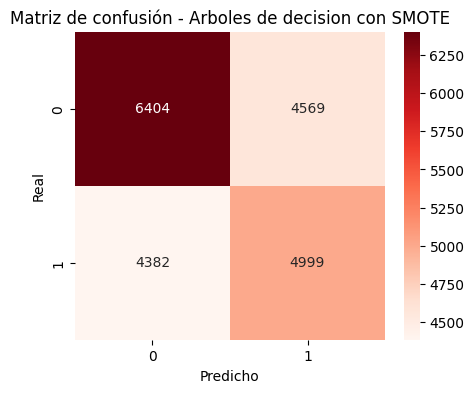

=== Arboles de decision con SMOTE ===
Accuracy: 0.560
Precision: 0.522
Recall: 0.533
F1: 0.528
AUC: 0.558

Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.59      0.58      0.59     10973
           1       0.52      0.53      0.53      9381

    accuracy                           0.56     20354
   macro avg       0.56      0.56      0.56     20354
weighted avg       0.56      0.56      0.56     20354



In [24]:
result_con = evaluar_modelo(pipeline_con_smote, X_test, y_test, nombre_modelo="Arboles de decision con SMOTE")

## 4.1.3 Arbol de decision con ADASYN

Gracias al balanceo existente en la clase objetivo, como se puede ver a continuacion, ADASYN no puede crear datos sinteticos para poder balancear, en este caso, no se tomara en cuenta.

In [ ]:
y_train.value_counts(normalize=True)

readmitted
0    0.539122
1    0.460878
Name: proportion, dtype: float64

In [26]:
df = pd.read_csv("C:\\Users\\taran\\OneDrive\\Desktop\\ML_PF_entrega3\\PF_GestHospitalClasificacion_Entrega3\\data\\PF_POSTPROCES_DATA_LIMPIA.csv")

In [27]:
X = df.drop("readmitted", axis=1)
y = df["readmitted"].map({"NO": 0, "SI": 1})  

In [28]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [32]:
# Definición del modelo base
modelo = DecisionTreeClassifier(
    criterion="gini",
    max_depth=None,
    random_state=42
)

pipeline_adasyn = ImbPipeline(steps=[
    ("preprocessor", preprocessor),
    ("adasyn", ADASYN(sampling_strategy=0.9, random_state=42, n_neighbors=3)),  # <--- clave
    ("classifier", modelo)
])


In [41]:
#pipeline_adasyn.fit(X_train, y_train)

In [42]:
#result_con = evaluar_modelo(pipeline_adasyn, X_test, y_test, nombre_modelo="Arboles de decision con ADASYN")

## 4.1.4 Arbol de decision con class weight=’balanced’


In [35]:
df = pd.read_csv("C:\\Users\\taran\\OneDrive\\Desktop\\ML_PF_entrega3\\PF_GestHospitalClasificacion_Entrega3\\data\\PF_POSTPROCES_DATA_LIMPIA.csv")

In [36]:
X = df.drop("readmitted", axis=1)
y = df["readmitted"].map({"NO": 0, "SI": 1})  

In [37]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [38]:
modelo_balanceado = DecisionTreeClassifier(
    criterion="gini",
    max_depth=None,
    random_state=42,
    class_weight="balanced"   # <-- clave
)

pipeline_balanceado = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", modelo_balanceado)
])

In [39]:
# Entrenamiento
pipeline_balanceado.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEnc...
       'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change'],
      dtype='object'))])),
                ('classifier',
                 DecisionTreeClassifier(class_weight='balanced',
                                        random_state=42))])

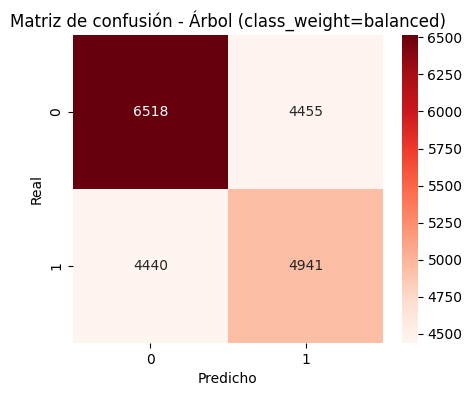

=== Árbol (class_weight=balanced) ===
Accuracy: 0.563
Precision: 0.526
Recall: 0.527
F1: 0.526
AUC: 0.560

Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.59      0.59      0.59     10973
           1       0.53      0.53      0.53      9381

    accuracy                           0.56     20354
   macro avg       0.56      0.56      0.56     20354
weighted avg       0.56      0.56      0.56     20354



In [45]:
# Evaluación con tu función existente
resultados_classweight = evaluar_modelo(
    pipeline_balanceado, X_test, y_test, nombre_modelo="Árbol (class_weight=balanced)"
)

## 4.1.5 Comparacion de resultados de tecnicas de balanceo para Arbol de decision


In [52]:
tabla_resultados = pd.DataFrame([
    result_sin,
    result_con,
    resultados_classweight
])

In [53]:
# Ordenar por Recall descendente
df_ordenado = tabla_resultados.sort_values(by="Recall", ascending=False).reset_index(drop=True)

# Mostrar tabla ordenada
print(df_ordenado)

                          Modelo  Accuracy  Precision    Recall        F1  \
0  Arboles de decision con SMOTE  0.560234   0.522471  0.532886  0.527627   
1  Árbol (class_weight=balanced)  0.562985   0.525862  0.526703  0.526282   
2  Arboles de decision sin SMOTE  0.558956   0.521448  0.523505  0.522475   

        AUC  
0  0.558250  
1  0.560356  
2  0.556385  
